In [3]:
import tensorflow as tf
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
import time
from sklearn.model_selection import train_test_split
import random

/Users/dweepa/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [215]:
def done():
    framerate = 44100
    duration=0.6
    freq=300
    t = np.linspace(0,duration,framerate*duration)
    data = np.sin(2*np.pi*freq*t)
    display(Audio(data, rate=framerate, autoplay=True))

In [368]:
X = pickle.load(open('../Data/X_train_triplet', 'rb'))
test = pickle.load(open('../Data/X_test_triplet', 'rb'))
y = pickle.load(open('../Data/y_test', 'rb'))

In [424]:
X = pickle.load(open('../Data/X_train_triplet', 'rb'))
test = pickle.load(open('../Data/X_test_triplet', 'rb'))
y = pickle.load(open('../Data/y_test', 'rb'))

# index = np.random.choice(X.shape[1],84, replace=False)  
index = np.arange(42)
x_test_anch = X[0][index]
x_test_pos = X[1][index]
x_test_neg = X[2][index]

def Diff(li1, li2):
    li_dif = [i for i in li1 if i not in li1 or i not in li2]
    return li_dif
index2 = Diff([i for i in range(X.shape[1])], index)

x_train_anch = X[0][index2]
x_train_pos = X[1][index2]
x_train_neg = X[2][index2]

X = [x_train_anch, x_train_pos, x_train_neg]
test = [x_test_anch, x_test_pos, x_test_neg]

In [425]:
class siamese:

    # Create model
    def __init__(self, loss='cos', network='net'):
        tf.reset_default_graph()
        self.x1 = tf.placeholder(tf.float32, [None, 978])
        self.x2 = tf.placeholder(tf.float32, [None, 978])
        self.x3 = tf.placeholder(tf.float32, [None, 978])
        
        if network=='net':
            self.network = self.normalnet
        if network=='densenet':
            self.network = self.densenet

        with tf.variable_scope("siamese") as scope:
            self.o1 = self.network(self.x1)
            scope.reuse_variables()
            self.o2 = self.network(self.x2)
            scope.reuse_variables()
            self.o3 = self.network(self.x3)

        if loss=='cos':
            self.loss = self.loss_with_cosine()
        if loss=='euc':
            self.loss = self.loss_with_euclid()
            
    def normalnet(self, x):
        weights = []
        
        fc1 = self.fc_layer(x, 1024, "fc1")
        ac1 = tf.nn.relu(fc1)
        
        fc2 = self.fc_layer(ac1, 1024, "fc2")
        ac2 = tf.nn.relu(fc2)
        
#         fc3 = self.fc_layer(ac2, 1024, "fc3")
#         ac3 = tf.nn.relu(fc3)
        
        fc4 = self.fc_layer(ac2, 32, "fc4")
        
        fc4 = tf.nn.l2_normalize(fc4, axis=1)
        return fc4

    def dense_network(self, x):
        weights = []
        
        fc1 = self.fc_layer(x, 400, "fc1")
        ac1 = tf.nn.relu(fc1)
        op_concat1 = tf.concat([x, ac1], axis=1)
        
        fc2 = self.fc_layer(op_concat1, 400, "fc2")
        ac2 = tf.nn.relu(fc2)
        op_concat2 = tf.concat([op_concat1, ac2], axis=1)
        
        fc3 = self.fc_layer(op_concat2, 400, "fc3")
        ac3 = tf.nn.relu(fc3)
        op_concat3 = tf.concat([op_concat2, ac3], axis=1)
        
        fc4 = self.fc_layer(op_concat3, 32, "fc4")
        
        fc4 = tf.nn.l2_normalize(fc4, axis=1)
        return fc4

    def fc_layer(self, bottom, n_weight, name):
        assert len(bottom.get_shape()) == 2
        n_prev_weight = bottom.get_shape()[1]
        initer = tf.truncated_normal_initializer(stddev=0.01)
        W = tf.get_variable(name+'W', dtype=tf.float32, shape=[n_prev_weight, n_weight], initializer=initer)
        b = tf.get_variable(name+'b', dtype=tf.float32, initializer=tf.constant(0.01, shape=[n_weight], dtype=tf.float32))
        fc = tf.nn.bias_add(tf.matmul(bottom, W), b)
        return fc

    def loss_with_euclid(self):  
        eucd2 = tf.pow(tf.subtract(self.o1, self.o2), 2)
        eucd2 = tf.sqrt(tf.reduce_sum(eucd2, axis=1))
        eucd2_mean = tf.reduce_mean(eucd2, axis=0)
        
        eucd3 = tf.pow(tf.subtract(self.o1, self.o3), 2)
        eucd3 = tf.sqrt(tf.reduce_sum(eucd3, axis=1))
        eucd3_mean = tf.reduce_mean(eucd3, axis=0)
        
        return eucd2_mean, eucd3_mean, eucd2, eucd3
    
    def loss_with_cosine(self):  
        eucd2 = tf.multiply(self.o1, self.o2)
        eucd2 = 1-tf.pow(tf.reduce_sum(eucd2, axis=1), 2)
        eucd2_mean = tf.reduce_mean(eucd2, axis=0)
        
        eucd3 = tf.multiply(self.o1, self.o3)
        eucd3 = 1-tf.pow(tf.reduce_sum(eucd3, axis=1), 2)
        eucd3_mean = tf.reduce_mean(eucd3, axis=0)
        
        return eucd2_mean, eucd3_mean, eucd2, eucd3

In [426]:
def run_network(s, epochs,X=X, test=test):    
    optim_pos = tf.train.AdamOptimizer(0.005).minimize(s.loss[0])
    optim_neg = tf.train.AdamOptimizer(0.005).minimize(-s.loss[1])
    with tf.Session() as session:  
        tf.initialize_all_variables().run()
        print("Initialized")

        feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]}

        p_loss = []
        n_loss = []
        train_acc_l = []
        test_acc_l = []
        print("Epoch\t\t+ Dist\t- Dist\t\tTrain\tTest")
        for a in range(epochs):        
            p_loss.append([])
            n_loss.append([])
            for b in range(len(X[0])):
                sys.stdout.write('\rEpoch %d:\t%d/%d' % (a, b+1, len(X[0])))
                feed_dict = {s.x1:X[0][b:b+1], s.x2:X[1][b:b+1], s.x3:X[2][b:b+1]}
                _, _, l = session.run([optim_pos, optim_neg, s.loss], feed_dict=feed_dict)
                p_loss[-1].append(l[0])
                n_loss[-1].append(l[1])
            p_loss[-1] = sum(p_loss[-1])/len(p_loss[-1])
            n_loss[-1] = sum(n_loss[-1])/len(n_loss[-1]) 
            
            trained = session.run([s.loss], feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]})
            pred = session.run([s.loss], feed_dict={s.x1:test[0], s.x2:test[1], s.x3:test[2]})
            
            train_acc = 100*(np.sum(trained[0][2]<=0.5)+np.sum(trained[0][3]>0.5))/len(X[0])/2
            test_acc = 100*(np.sum(pred[0][2]<=0.5)+np.sum(pred[0][3]>0.5))/len(test[0])/2 
            
            train_acc_l.append(train_acc)
            test_acc_l.append(test_acc)
            
#             print(" ", p_loss[-1], n_loss[-1], train_acc, test_acc)
            print(f"\rEpoch {a}:\t{'{0:.4f}'.format(p_loss[-1])}\t{'{0:.4f}'.format(n_loss[-1])}\t\t{'{0:.2f}'.format(train_acc)}\t{'{0:.2f}'.format(test_acc)}")

        embeddings = session.run([s.o1, s.o2, s.o3], feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]})
        trained = session.run([s.loss], feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]})
        pred = session.run([s.loss], feed_dict={s.x1:test[0], s.x2:test[1], s.x3:test[2]})
        
        return embeddings, trained, pred, p_loss, n_loss, train_acc_l, test_acc_l

In [427]:
def graph(p_loss, n_loss, train_acc_l=None, test_acc_l=None):
    plt.figure(figsize=(20, 6))
    plt.plot(np.arange(epochs), p_loss, label='positive')
    plt.plot(np.arange(epochs), n_loss, label='negative')
    plt.legend()
    plt.title("Loss over epochs")
    plt.show()
    
    if train_acc_l!=None and test_acc_l!=None:
        plt.figure(figsize=(20, 6))
        plt.plot(np.arange(epochs), train_acc_l, label='train')
        plt.plot(np.arange(epochs), test_acc_l, label='test')
        plt.legend()
        plt.title("Accuracy over epochs")
        plt.show()

In [428]:
epochs = 10

### Euclidean

In [429]:
s = siamese("euc", "net")

In [430]:
embeddings, trained, pred, p_loss, n_loss, train_acc_l, test_acc_l = run_network(s, epochs)

Initialized
Epoch		+ Dist	- Dist		Train	Test
Epoch 0:	0.4531	0.8646		61.90	69.05
Epoch 1:	0.3500	0.9866		71.83	44.05
Epoch 2:	0.2320	0.9686		75.93	47.62
Epoch 3:	0.2682	1.1923		71.30	47.62
Epoch 4:	0.2380	1.1295		74.07	48.81
Epoch 5:	0.2986	1.2179		80.29	47.62
Epoch 6:	0.2169	1.3557		82.80	59.52
Epoch 7:	0.2257	1.4200		79.76	54.76
Epoch 8:	0.1963	1.5012		86.51	50.00
Epoch 9:	0.1781	1.5623		85.32	48.81


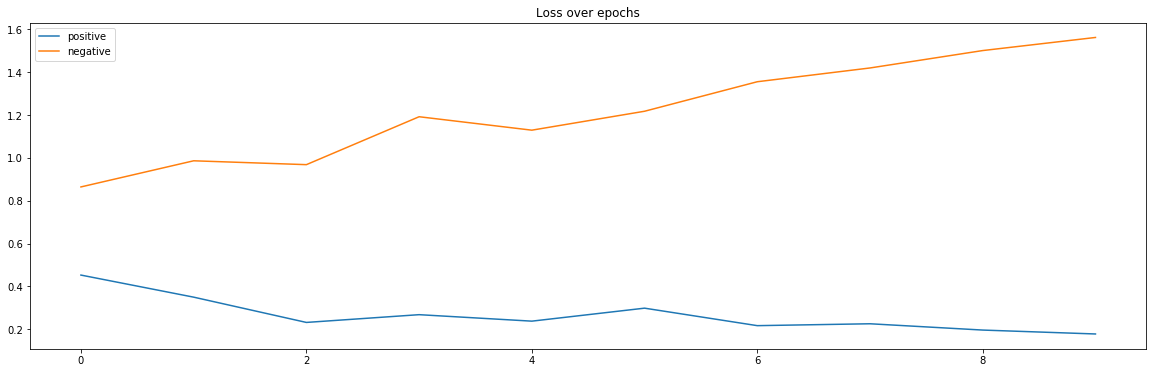

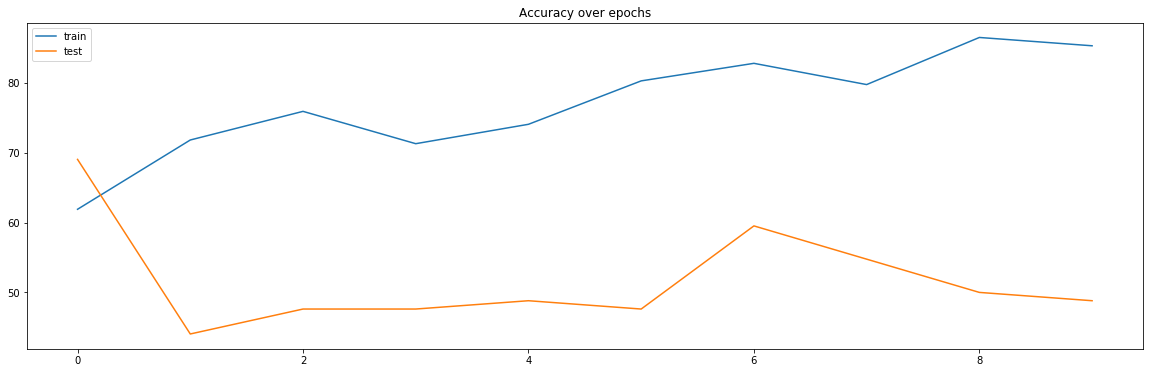

In [431]:
graph(p_loss, n_loss, train_acc_l, test_acc_l)

In [432]:
p = np.sum(trained[0][2]<=0.5)
n = np.sum(trained[0][3]>0.5)
print("Training Accuracy", (p+n)/len(X[0])/2)

p = np.sum(pred[0][2]<=0.5)
n = np.sum(pred[0][3]>0.5)
print("Testing Accuracy", (p+n)/len(test[0])/2)

Training Accuracy 0.8531746031746031
Testing Accuracy 0.4880952380952381


### Cosine

In [433]:
s = siamese("cos", "net")

In [434]:
embeddings, trained, pred, p_loss, n_loss, train_acc_l, test_acc_l = run_network(s, epochs)

Initialized
Epoch		+ Dist	- Dist		Train	Test
Epoch 0:	0.3076	0.4540		61.24	48.81
Epoch 1:	0.3199	0.5985		71.83	54.76
Epoch 2:	0.2615	0.6963		77.12	50.00
Epoch 3:	0.2497	0.7907		81.22	48.81
Epoch 4:	0.2139	0.8442		81.48	54.76
Epoch 5:	0.2228	0.8714		84.13	51.19
Epoch 6:	0.1739	0.8759		85.71	51.19
Epoch 7:	0.1429	0.8948		86.90	41.67
Epoch 8:	0.1424	0.9288		89.81	50.00
Epoch 9:	0.1867	0.8968		88.89	55.95


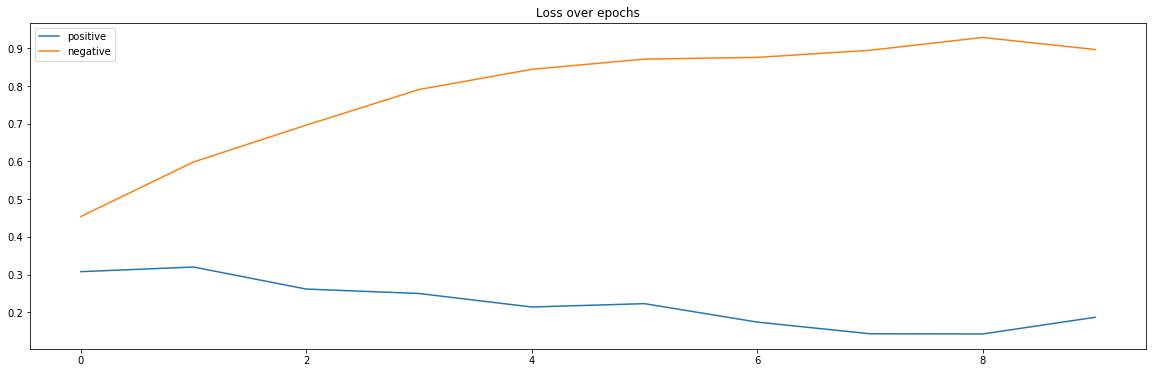

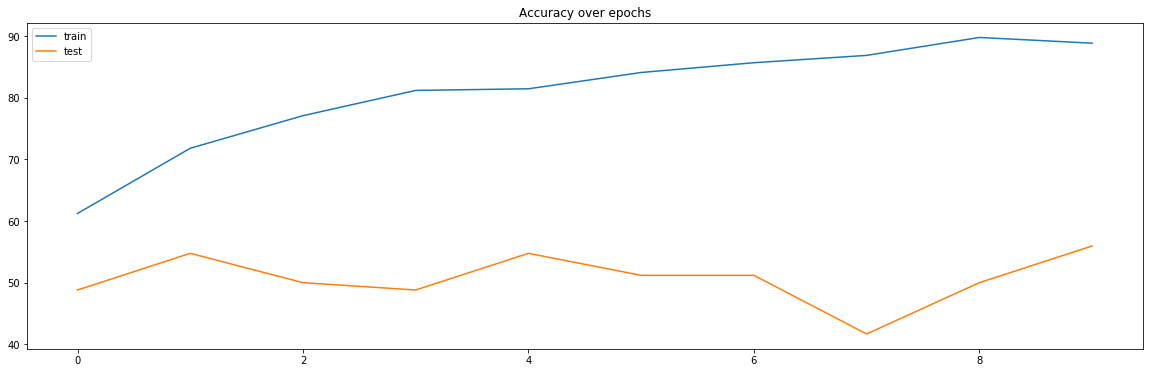

In [435]:
graph(p_loss, n_loss, train_acc_l, test_acc_l)

In [436]:
p = np.sum(trained[0][2]<=0.5)
n = np.sum(trained[0][3]>0.5)
print("Training Accuracy", (p+n)/len(X[0])/2)

p = np.sum(pred[0][2]<=0.5)
n = np.sum(pred[0][3]>0.5)
print("Testing Accuracy", (p+n)/len(test[0])/2)

Training Accuracy 0.8888888888888888
Testing Accuracy 0.5595238095238095


In [328]:
i = 3
while i:
    i-=1
    done()
    time.sleep(1.2)

/home/kavya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


In [16]:
train_pert = pickle.load(open('../Data/train_perts', 'rb'))
test_pert = np.asarray(pickle.load(open('../Data/test_perts', 'rb')))

In [23]:
all_pert = np.concatenate((train_pert,test_pert))
all_pert

(2170,)

In [32]:
# cross validation code WIP

from sklearn.model_selection import KFold
def cross_validate(session, splitsize):
    kf = KFold(n_splits=splitsize)
    results = []
    for train_idx, val_idx in kf.split(all_pert):
        train_perts = all_pert[train_idx]
        val_perts = all_pert[val_idx]
        print(train_perts.shape,val_perts.shape)
        #X_train = generate_data(full_data,train_perts,42)
        #X_val = generate_data(full_data,val_perts,42)
        embeddings, trained, pred, p_loss, n_loss, train_acc_l, test_acc_l = run_network(session, epochs, X_train, X_val)
        
        p = np.sum(trained[0][2]<=0.5)
        n = np.sum(trained[0][3]>0.5)
        train_acc = ((p+n)/len(X[0])/2)

        p = np.sum(pred[0][2]<=0.5)
        n = np.sum(pred[0][3]>0.5)
        val_acc = ((p+n)/len(test[0])/2)
        
        accuracy = (train_acc, val_acc)
        results.append(accuracy)
    return results

with tf.Session() as session:
    result = cross_validate(session)
    print "Cross-validation result: %s" % result
    

SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Cross-validation result: %s" % result)? (<ipython-input-32-5573bdad846f>, line 29)